## ****House Price Prediction Project****

#### **Overview**

This project aims to predict house selling prices based on various features like area, number of bedrooms, location, etc. using the dataset from Kaggle's "House Prices: Advanced Regression Techniques" competition.

***Step 1: Data Loading and Initial Exploration***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb

In [2]:
# Load the data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
# Initial exploration
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("\nTrain data columns:\n", train_data.columns)
print("\nMissing values in train data:\n", train_data.isnull().sum().sort_values(ascending=False).head(20))

Train data shape: (1460, 81)
Test data shape: (1459, 80)

Train data columns:
 Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFini

***Step 2: Exploratory Data Analysis (EDA)***

In [4]:
# Set style for plots
sns.set_style("whitegrid")

Text(0.5, 1.0, 'SalePrice Distribution')

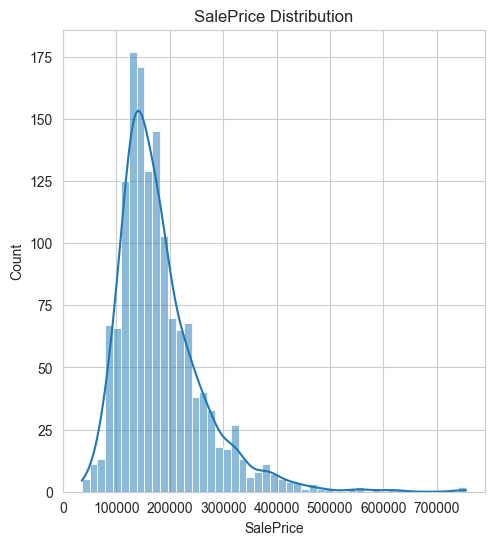

In [5]:
# 1. Target variable analysis (SalePrice)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(train_data['SalePrice'], kde=True)
plt.title('SalePrice Distribution')

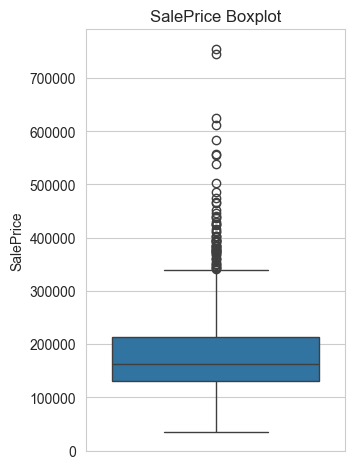

In [6]:
plt.subplot(1, 2, 2)
sns.boxplot(y=train_data['SalePrice'])
plt.title('SalePrice Boxplot')
plt.tight_layout()
plt.show()

In [7]:
# Log transformation of SalePrice (often helps with skewed target variables)
train_data['LogSalePrice'] = np.log1p(train_data['SalePrice'])

Text(0.5, 1.0, 'Log(SalePrice) Distribution')

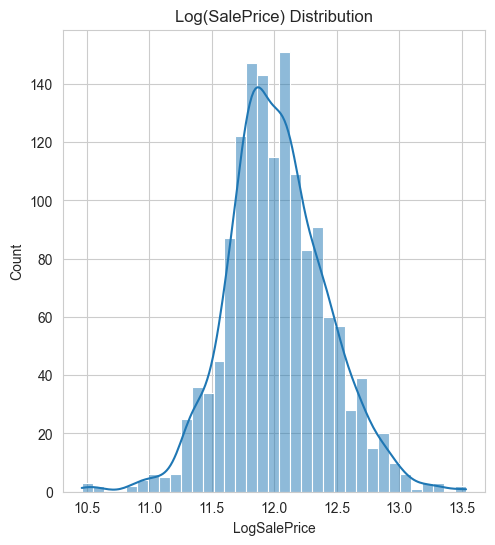

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(train_data['LogSalePrice'], kde=True)
plt.title('Log(SalePrice) Distribution')

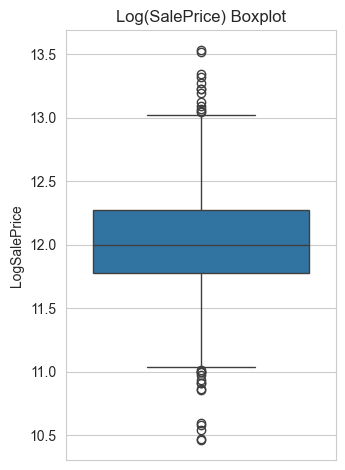

In [9]:
plt.subplot(1, 2, 2)
sns.boxplot(y=train_data['LogSalePrice'])
plt.title('Log(SalePrice) Boxplot')
plt.tight_layout()
plt.show()

In [10]:
# 2. Numerical features analysis
numerical_features = train_data.select_dtypes(include=['int64', 'float64']).columns
numerical_features = numerical_features.drop(['Id', 'SalePrice', 'LogSalePrice'])

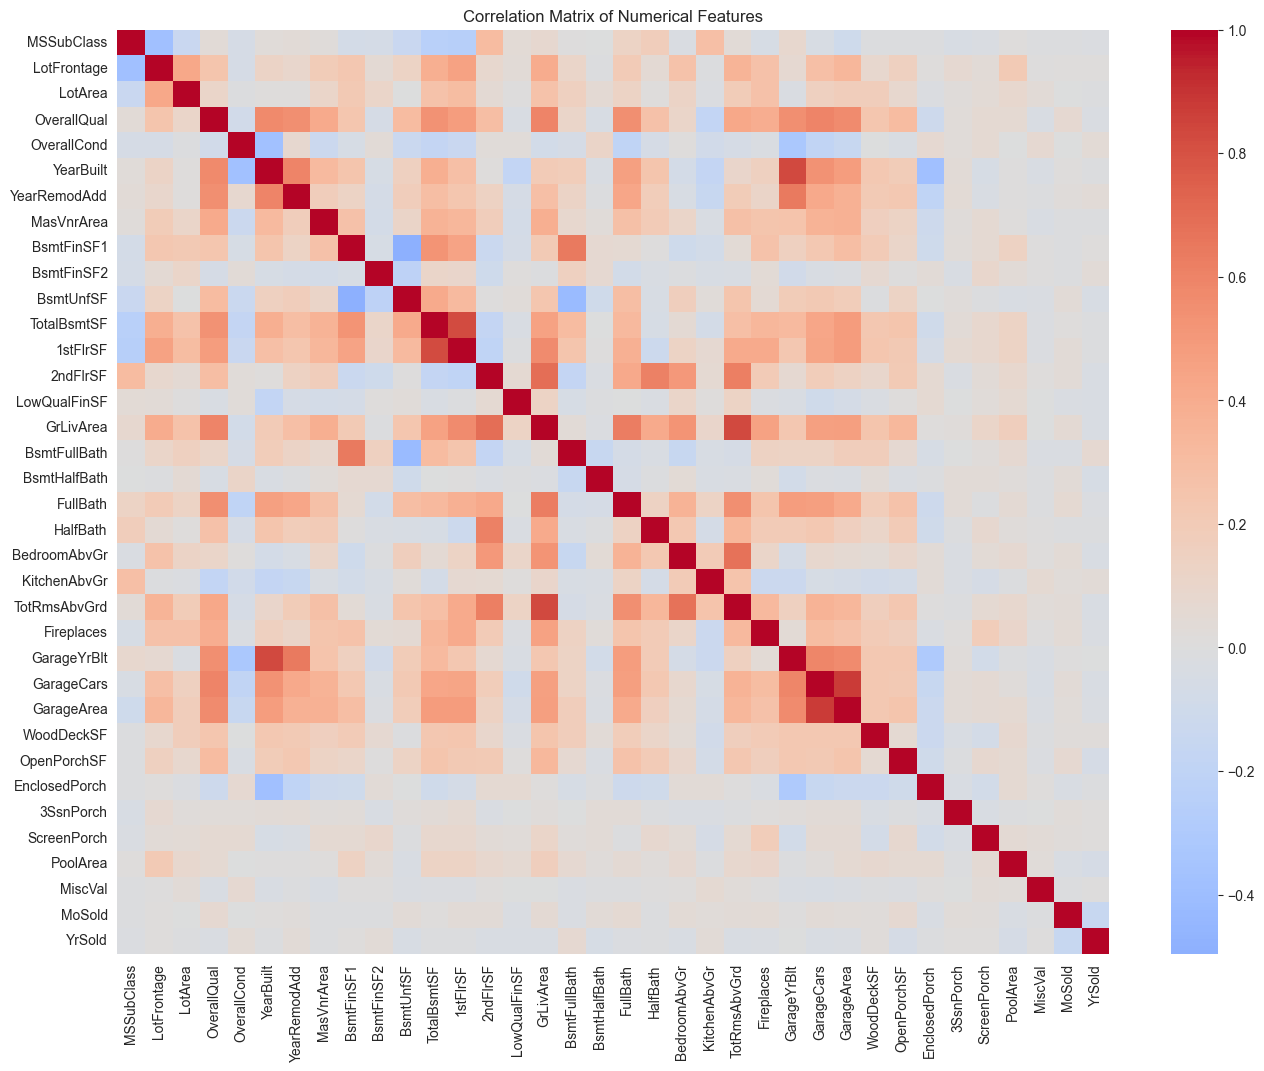

In [11]:
# Correlation matrix
corr_matrix = train_data[numerical_features].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [12]:
# Select only numerical columns for correlation analysis
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns

# Calculate correlation with SalePrice
corr_with_price = train_data[numerical_cols].corr()['SalePrice'].sort_values(ascending=False)

print("Top 10 positively correlated features:\n", corr_with_price.head(10))
print("\nTop 10 negatively correlated features:\n", corr_with_price.tail(10))

Top 10 positively correlated features:
 SalePrice       1.000000
LogSalePrice    0.948374
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
Name: SalePrice, dtype: float64

Top 10 negatively correlated features:
 BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


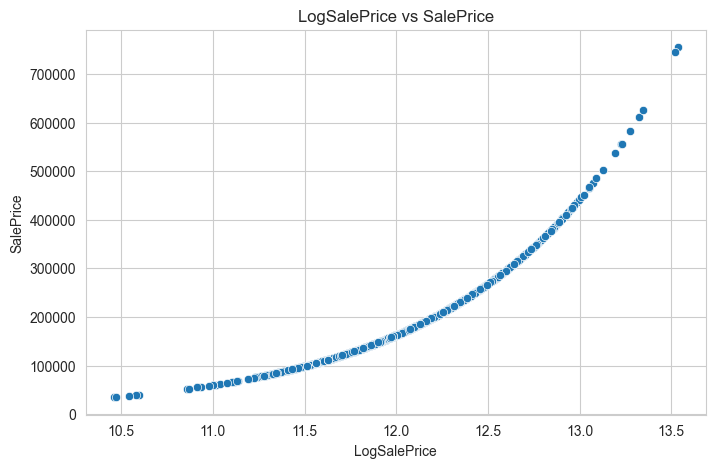

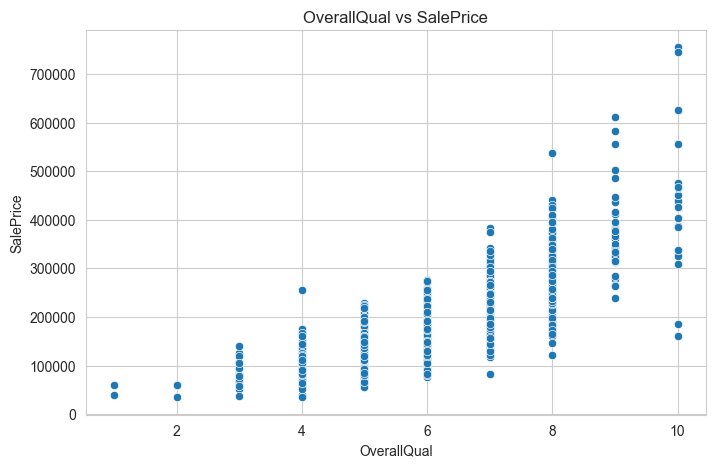

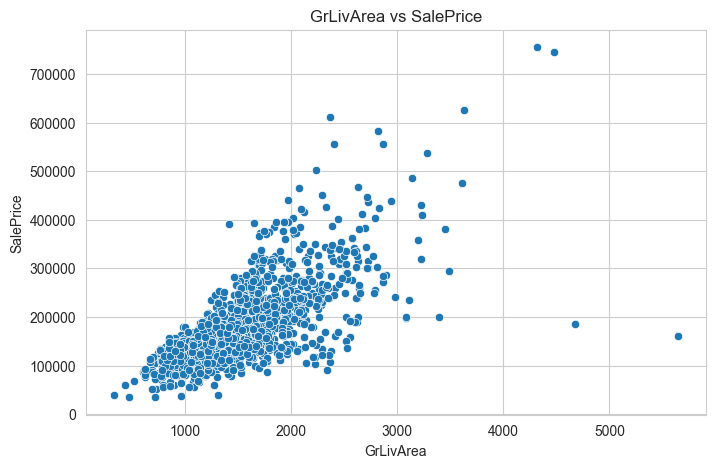

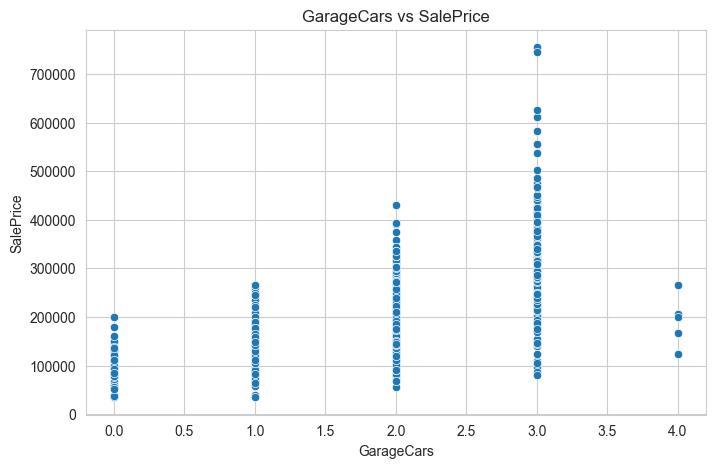

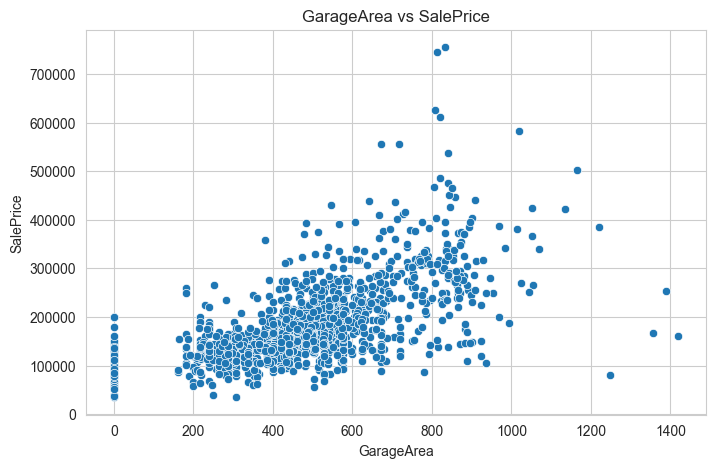

In [13]:
# Scatter plots of top correlated features
top_features = corr_with_price.index[1:6]  # excluding SalePrice itself
for feature in top_features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=train_data[feature], y=train_data['SalePrice'])
    plt.title(f'{feature} vs SalePrice')
    plt.show()

In [14]:
# 3. Categorical features analysis
categorical_features = train_data.select_dtypes(include=['object']).columns

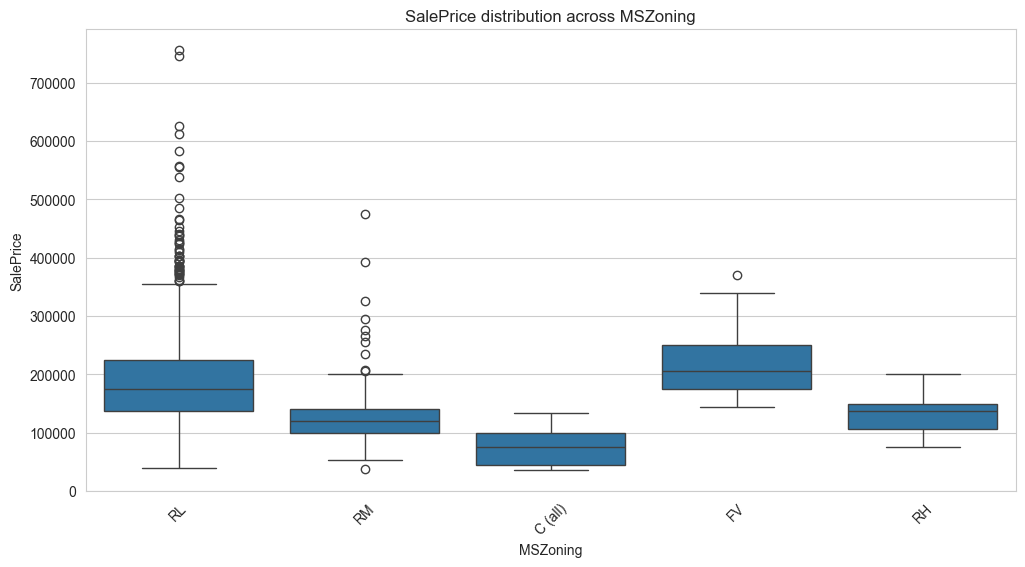

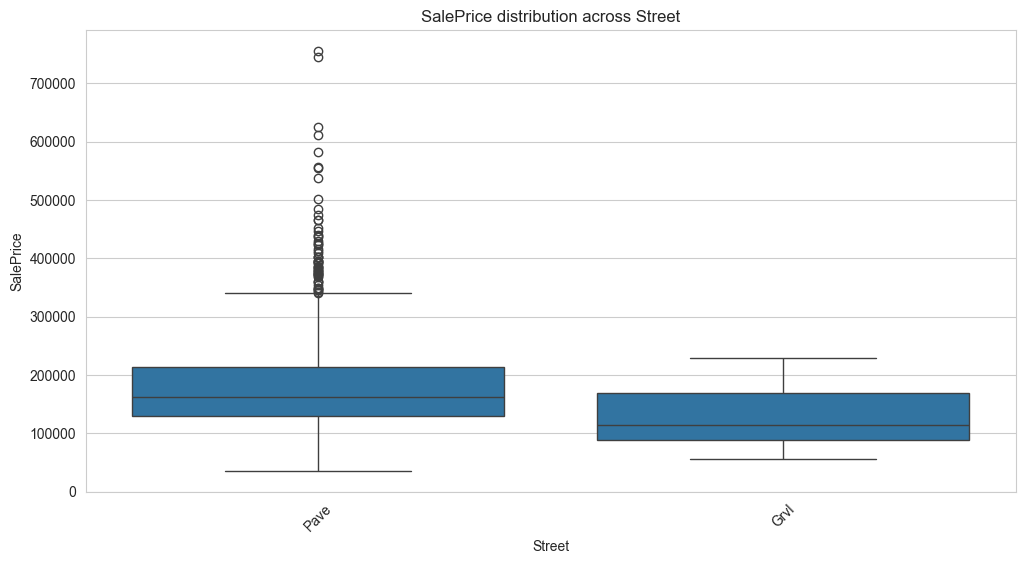

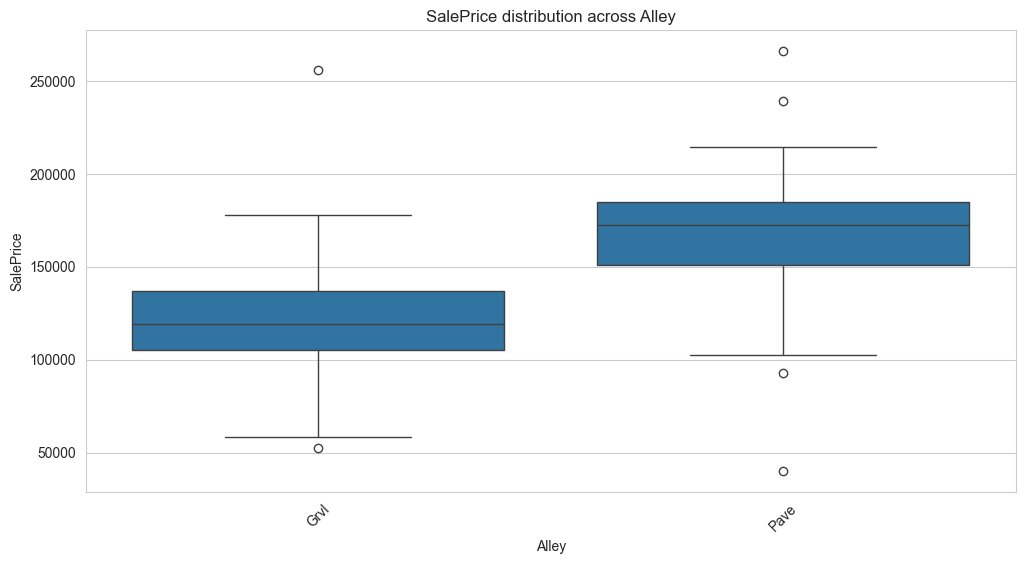

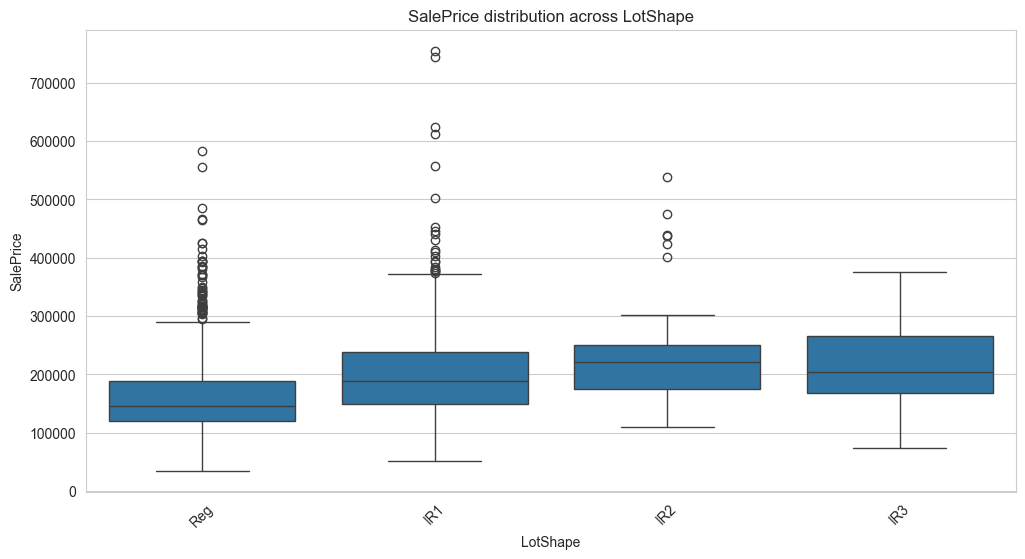

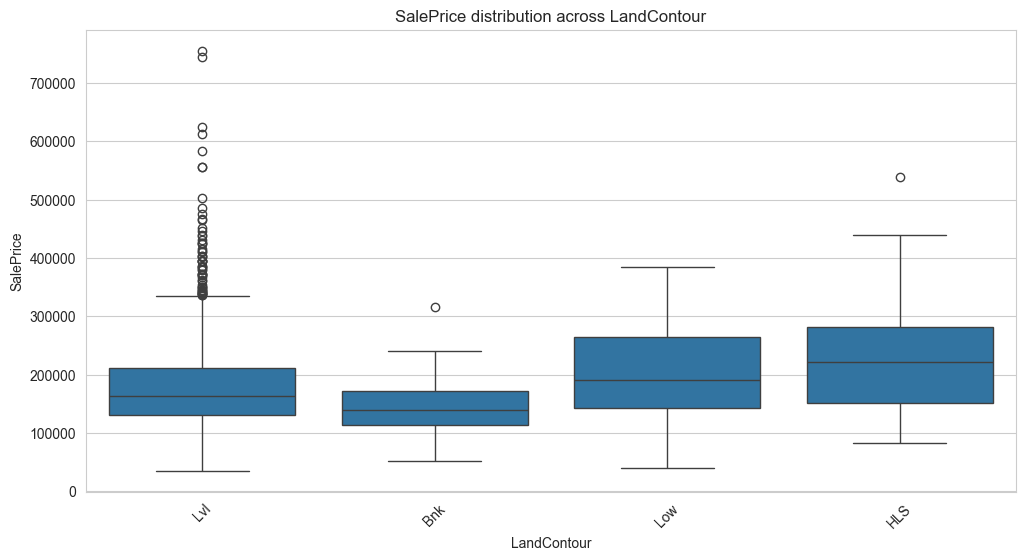

In [15]:
# Boxplots for some categorical features
for feature in categorical_features[:5]:  # just show first 5 to save space
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=train_data[feature], y=train_data['SalePrice'])
    plt.xticks(rotation=45)
    plt.title(f'SalePrice distribution across {feature}')
    plt.show()

In [16]:
# 4. Missing data analysis
missing_data = train_data.isnull().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data > 0]

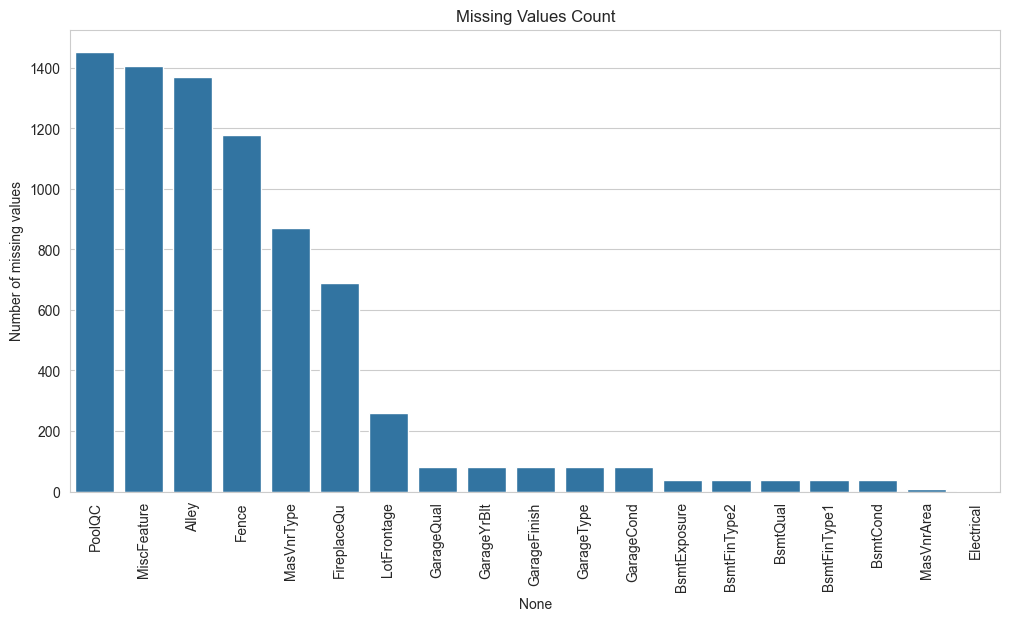

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_data.index, y=missing_data.values)
plt.xticks(rotation=90)
plt.title('Missing Values Count')
plt.ylabel('Number of missing values')
plt.show()

***Step 3: Data Preprocessing***

In [18]:
# Separate features and target
X = train_data.drop(['Id', 'SalePrice', 'LogSalePrice'], axis=1)
y = train_data['LogSalePrice']  # Using log-transformed target

In [19]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [21]:
# Preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [22]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [23]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

In [24]:
# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)

***Step 4: Model Building and Evaluation***

In [25]:
# Initialize models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

In [26]:
# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_preprocessed, y_train)
    y_pred = model.predict(X_val_preprocessed)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    results[name] = rmse
    print(f"{name}: RMSE = {rmse:.4f}")

Random Forest: RMSE = 0.1475
Gradient Boosting: RMSE = 0.1376
XGBoost: RMSE = 0.1447


In [27]:
# Feature importance for the best model
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]

In [28]:
# Get feature names
numerical_feature_names = numerical_features
categorical_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_feature_names, categorical_feature_names])

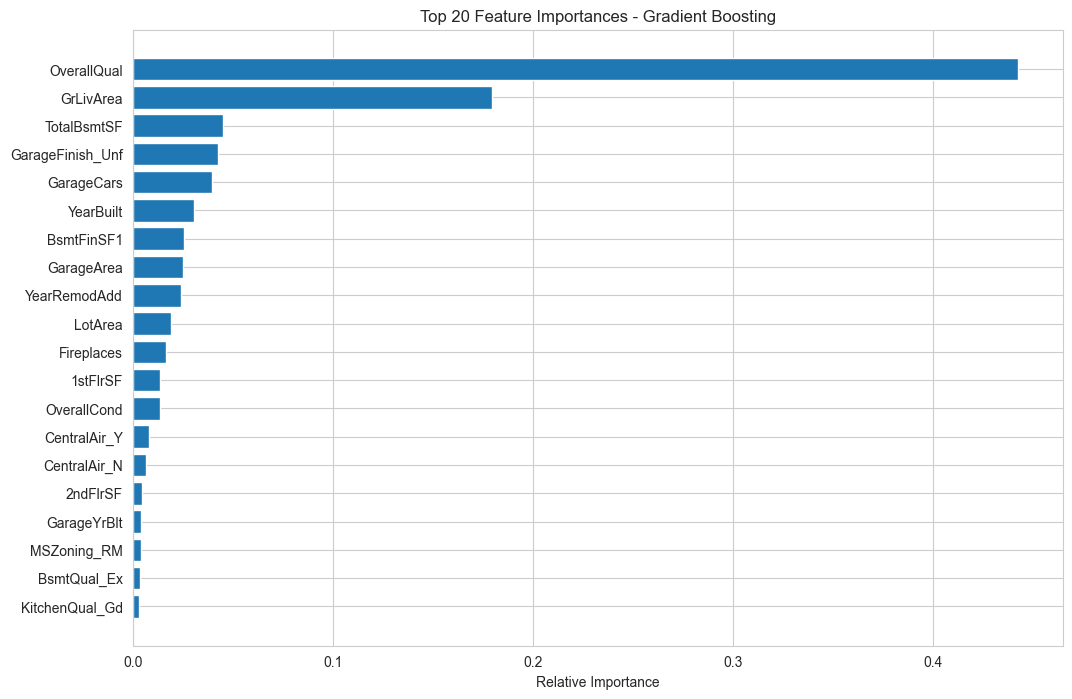

In [29]:
# Plot feature importance
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[-20:]  # top 20 features
    
    plt.figure(figsize=(12, 8))
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [all_feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

***Step 5: Final Model and Prediction***

In [30]:
# Retrain best model on full training data
X_full = preprocessor.fit_transform(X)
best_model.fit(X_full, y)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [31]:
# Preprocess test data
test_ids = test_data['Id']
X_test = test_data.drop(['Id'], axis=1)
X_test_preprocessed = preprocessor.transform(X_test)

In [32]:
# Make predictions
test_preds = best_model.predict(X_test_preprocessed)
test_preds = np.expm1(test_preds)  # Convert back from log scale

In [33]:
# Create submission file
submission = pd.DataFrame({'Id': test_ids, 'SalePrice': test_preds})
submission.to_csv('submission.csv', index=False)
print("Submission file created!")

Submission file created!


## ****Key Findings from EDA:****

### ***Target Variable (SalePrice):***

* Right-skewed distribution, which benefits from log transformation

* Some outliers in the higher price range

### ***Numerical Features:***

**Strong positive correlation with:**

* OverallQual (overall material and finish quality)

* GrLivArea (above grade living area square feet)

* GarageCars/GarageArea (garage size)

**Strong negative correlation with:**

* Age-related features (older houses sell for less)

### ***Categorical Features:***

* Neighborhood shows significant price variation

* HouseStyle and OverallCond affect prices

* MSZoning (zoning classification) impacts prices

### ***Missing Data:***

* PoolQC, MiscFeature, Alley have >80% missing values

* FireplaceQu, Fence have ~50% missing values

* Garage-related features have ~5% missing values